# Week 5: Pharmacogenomics Analysis

## Analysis Pipeline
1. Download reference genome (chromosome 10)
2. Align Illumina and PacBio reads with minimap2
3. Call variants with bcftools
4. Phase variants with HapCUT2
5. Compare VCFs and identify discordant variants
6. Determine star-alleles using PharmVar database

## Step 0: Setup

### Install Dependencies

In [1]:
import os
import sys
import subprocess
import pandas as pd
from pathlib import Path
import gzip
from collections import defaultdict
import urllib.request
import shutil
import bz2
import platform

### Set up working directories

In [2]:
notebook_dir = Path.cwd()
data_dir = notebook_dir / "data"
data_dir.mkdir(parents=True, exist_ok=True)
print(f"Working directory: {notebook_dir}")
print(f"Data directory: {data_dir}")

Working directory: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code
Data directory: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data


## Step 1:

All target genes are located on chromosome 10:
- CYP2C8
- CYP2C9
- CYP2C19

Locate these genes in the reference genome. Use Genome Browser. We will focus on the hg38 (or GRCh38) version of the human genome. Also, make sure to download the reference genome!

Note: you will need to download the human genome for this step; however, note that you do not need the whole human genome. Just focus on the chromosome that contains those genes! The reference should basically be a single FASTA file (extension: .fa or .fasta).

Expected output: a single FASTA file.

In [3]:
# Download chromosome 10 reference genome
chr10_url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/chromosomes/chr10.fa.gz"
chr10_gz_path = data_dir / "chr10.fa.gz"
chr10_fa_path = data_dir / "chr10.fa"

print("DOWNLOADING REFERENCE GENOME")

if not chr10_fa_path.exists():
    print(f"Downloading chromosome 10 from UCSC Genome Browser")
    print(f"Source: {chr10_url}")
    print(f"Target: {chr10_gz_path}")
    
    try:
        urllib.request.urlretrieve(chr10_url, chr10_gz_path)
        print("Download complete!")
        
        print(f"Decompressing {chr10_gz_path.name}...")
        with gzip.open(chr10_gz_path, 'rb') as f_in:
            with open(chr10_fa_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        print(f"Decompression complete!")
        print(f"Output file: {chr10_fa_path}")
        
        # Remove compressed file to save space
        chr10_gz_path.unlink()
        print(f"Removed compressed file: {chr10_gz_path}")
                
    except Exception as e:
        print(f"Error during download: {e}")
        raise
else:
    print(f"Reference genome already exists: {chr10_fa_path}")

print("")

DOWNLOADING REFERENCE GENOME
Source: https://hgdownload.soe.ucsc.edu/goldenPath/hg38/chromosomes/chr10.fa.gz
Target: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/chr10.fa.gz
Download complete!
Decompressing chr10.fa.gz...
Decompression complete!
Output file: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/chr10.fa
Removed compressed file: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/chr10.fa.gz



### Download Sequencing Data

In [4]:
# Download Illumina data
illumina_url = "https://github.com/inumanag/fall25-csc-bioinf/raw/refs/heads/main/week4/data/illumina.fq.bz2"
illumina_bz2_path = data_dir / "illumina.fq.bz2"
illumina_fq_path = data_dir / "illumina.fq"

if not illumina_fq_path.exists():
    print(f"Downloading Illumina data from GitHub")
    print(f"Source: {illumina_url}")
    
    try:
        urllib.request.urlretrieve(illumina_url, illumina_bz2_path)
        print("Download complete!")
        
        print(f"Decompressing {illumina_bz2_path.name}...")
        with bz2.open(illumina_bz2_path, 'rb') as f_in:
            with open(illumina_fq_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        print(f"Decompression complete!")
        print(f"Output file: {illumina_fq_path}")
        
        # Remove compressed file
        illumina_bz2_path.unlink()
        print(f"Removed compressed file: {illumina_bz2_path}")
                
    except Exception as e:
        print(f"Error during download: {e}")
        raise
else:
    print(f"Illumina data already exists: {illumina_fq_path}")

print("")

pacbio_url = "https://github.com/inumanag/fall25-csc-bioinf/raw/refs/heads/main/week4/data/pacbio.fq.bz2"
pacbio_bz2_path = data_dir / "pacbio.fq.bz2"
pacbio_fq_path = data_dir / "pacbio.fq"

if not pacbio_fq_path.exists():
    print(f"Downloading PacBio data from GitHub")
    print(f"Source: {pacbio_url}")
    
    try:
        urllib.request.urlretrieve(pacbio_url, pacbio_bz2_path)
        print("Download complete!")
        
        print(f"Decompressing {pacbio_bz2_path.name}...")
        with bz2.open(pacbio_bz2_path, 'rb') as f_in:
            with open(pacbio_fq_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        print(f"Decompression complete!")
        print(f"Output file: {pacbio_fq_path}")
        
        pacbio_bz2_path.unlink()
        print(f"Removed compressed file: {pacbio_bz2_path}")
                
    except Exception as e:
        print(f"Error during download: {e}")
        raise
else:
    print(f"PacBio data already exists: {pacbio_fq_path}")

print("")

Source: https://github.com/inumanag/fall25-csc-bioinf/raw/refs/heads/main/week4/data/illumina.fq.bz2
Download complete!
Decompressing illumina.fq.bz2...
Decompression complete!
Output file: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/illumina.fq
Removed compressed file: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/illumina.fq.bz2

Source: https://github.com/inumanag/fall25-csc-bioinf/raw/refs/heads/main/week4/data/pacbio.fq.bz2
Download complete!
Decompressing pacbio.fq.bz2...
Decompression complete!
Output file: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/pacbio.fq
Removed compressed file: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/pacbio.fq.bz2



## Step 2:

Align all samples in FASTQ format to the human genome (version GRCh38). Use minimap2 for the alignment. Make sure to use appropriate parameters for each technology.

Note: you will need to download the human genome for this step; however, note that you do not need the whole human genome. Just focus on the chromosome that contains those genes! The reference should basically be a single FASTA file (extension: .fa).

Expected output: two BAM files and two BAI files (one of those for each sample).

### Index Reference Genome

In [5]:
print("INDEXING REFERENCE GENOME")

chr10_mmi_path = data_dir / "chr10.mmi"

if not chr10_mmi_path.exists():
    print(f"Creating minimap2 index for {chr10_fa_path}")
    cmd = [
        "minimap2",
        "-d", str(chr10_mmi_path),
        str(chr10_fa_path)
    ]
    
    result = subprocess.run(cmd, check=True, capture_output=True, text=True)
    print(result.stderr)  # minimap2 outputs to stderr
    print(f"Index created: {chr10_mmi_path}")

else:
    print(f"Index already exists: {chr10_mmi_path}")

print("")

INDEXING REFERENCE GENOME
Creating minimap2 index for /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/chr10.fa
[M::mm_idx_gen::4.498*0.79] collected minimizers
[M::mm_idx_gen::5.090*1.04] sorted minimizers
[M::main::66.485*0.16] loaded/built the index for 1 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::66.641*0.16] distinct minimizers: 16061920 (79.91% are singletons); average occurrences: 1.563; average spacing: 5.329; total length: 133797422
[M::main] Version: 2.30-r1287
[M::main] CMD: minimap2 -d /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/chr10.mmi /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/chr10.fa
[M::main] Real time: 66.698 sec; CPU: 10.835 sec; Peak RSS: 1.097 GB

Index created: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/chr10.mmi



### Align Illumina Reads

In [6]:
print("ALIGNING ILLUMINA READS")

illumina_sam = data_dir / "illumina.sam"
illumina_bam = data_dir / "illumina.bam"
illumina_sorted_bam = data_dir / "illumina_sorted.bam"
illumina_bai = data_dir / "illumina_sorted.bam.bai"

if not illumina_sorted_bam.exists():
    print("Aligning Illumina reads with minimap2 (sr preset for short reads)")
    
    align_cmd = [
        "minimap2",
        "-ax", "sr",
        "-t", "4",
        str(chr10_mmi_path),
        str(illumina_fq_path)
    ]
    
    with open(illumina_sam, 'w') as sam_file:
        result = subprocess.run(align_cmd, stdout=sam_file, stderr=subprocess.PIPE, text=True, check=True)
        print(result.stderr)  # minimap2 outputs to stderr
    
    print(f"Alignment complete: {illumina_sam}")
    
    # Convert SAM to BAM
    print("Converting SAM to BAM...")
    subprocess.run([
        "samtools", "view",
        "-b", "-o", str(illumina_bam),
        str(illumina_sam)
    ], check=True)
    print(f"BAM created: {illumina_bam}")
    
    # Sort BAM
    print("Sorting BAM file...")
    subprocess.run([
        "samtools", "sort",
        "-o", str(illumina_sorted_bam),
        str(illumina_bam)
    ], check=True)
    print(f"Sorted BAM created: {illumina_sorted_bam}")
    
    # Index BAM
    print("Indexing BAM file...")
    subprocess.run([
        "samtools", "index",
        str(illumina_sorted_bam)
    ], check=True)
    print(f"Index created: {illumina_bai}")
    
    # Clean up intermediate files
    illumina_sam.unlink()
    illumina_bam.unlink()
    print("Cleaned up intermediate files")
    
    print(f"\nFinal output: {illumina_sorted_bam}")
    print(f"Final index: {illumina_bai}")
else:
    print(f"Illumina alignment already exists: {illumina_sorted_bam}")

print("")

ALIGNING ILLUMINA READS
Aligning Illumina reads with minimap2 (sr preset for short reads)
[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::65.195*0.10] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::65.195*0.10] mid_occ = 1000
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::65.344*0.11] distinct minimizers: 16061920 (79.91% are singletons); average occurrences: 1.563; average spacing: 5.329; total length: 133797422
[M::worker_pipeline::108.908*0.47] mapped 309505 sequences
[M::main] Version: 2.30-r1287
[M::main] CMD: minimap2 -ax sr -t 4 /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/chr10.mmi /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/illumina.fq
[M::main] Real time: 108.929 sec; CPU: 51.164 sec; Peak RSS: 0.944 GB

Alignment complete: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/illumina.sam
Converting 

### Align PacBio Reads

In [7]:
print("ALIGNING PACBIO READS")

pacbio_sam = data_dir / "pacbio.sam"
pacbio_bam = data_dir / "pacbio.bam"
pacbio_sorted_bam = data_dir / "pacbio_sorted.bam"
pacbio_bai = data_dir / "pacbio_sorted.bam.bai"

if not pacbio_sorted_bam.exists():
    print("Aligning PacBio reads with minimap2 (map-pb preset for PacBio)")
    
    align_cmd = [
        "minimap2",
        "-ax", "map-pb",
        "-t", "4",
        str(chr10_mmi_path),
        str(pacbio_fq_path)
    ]
    
    with open(pacbio_sam, 'w') as sam_file:
        result = subprocess.run(align_cmd, stdout=sam_file, stderr=subprocess.PIPE, text=True, check=True)
        print(result.stderr)  # minimap2 outputs to stderr
    
    print(f"Alignment complete: {pacbio_sam}")
    
    print("Converting SAM to BAM...")
    subprocess.run([
        "samtools", "view",
        "-b", "-o", str(pacbio_bam),
        str(pacbio_sam)
    ], check=True)
    print(f"BAM created: {pacbio_bam}")
    
    print("Sorting BAM file...")
    subprocess.run([
        "samtools", "sort",
        "-o", str(pacbio_sorted_bam),
        str(pacbio_bam)
    ], check=True)
    print(f"Sorted BAM created: {pacbio_sorted_bam}")
    
    print("Indexing BAM file...")
    subprocess.run([
        "samtools", "index",
        str(pacbio_sorted_bam)
    ], check=True)
    print(f"Index created: {pacbio_bai}")
    
    pacbio_sam.unlink()
    pacbio_bam.unlink()
    print("Cleaned up intermediate files")
    
    print(f"\nFinal output: {pacbio_sorted_bam}")
    print(f"Final index: {pacbio_bai}")
else:
    print(f"PacBio alignment already exists: {pacbio_sorted_bam}")

print("")

ALIGNING PACBIO READS
Aligning PacBio reads with minimap2 (map-pb preset for PacBio)
[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::63.077*0.11] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::63.355*0.11] mid_occ = 178
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::63.502*0.11] distinct minimizers: 16061920 (79.91% are singletons); average occurrences: 1.563; average spacing: 5.329; total length: 133797422
[M::worker_pipeline::65.887*0.19] mapped 3063 sequences
[M::main] Version: 2.30-r1287
[M::main] CMD: minimap2 -ax map-pb -t 4 /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/chr10.mmi /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/pacbio.fq
[M::main] Real time: 65.907 sec; CPU: 12.844 sec; Peak RSS: 0.748 GB

Alignment complete: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/pacbio.sam
Converting SAM to BAM

## Step 3: Call Variants with bcftools

Find all variants in each sample for all genes of interest and obtain VCF files.

**Expected output:** Two VCF files (one for each sample)

In [8]:
print("VARIANT CALLING WITH BCFTOOLS")

illumina_vcf = data_dir / "illumina_variants.vcf.gz"
pacbio_vcf = data_dir / "pacbio_variants.vcf.gz"

def call_variants(bam_path, vcf_path, sample_name):
    
    if vcf_path.exists():
        print(f"\n{sample_name} VCF already exists: {vcf_path}")
        return
    
    print(f"Calling variants for {sample_name}")
    print(f"Running bcftools mpileup")
    mpileup_cmd = [
        "bcftools", "mpileup",
        "-f", str(chr10_fa_path),  # reference genome
        "-Ou",                      # uncompressed BCF output
        "-q", "20",                 # minimum mapping quality
        "-Q", "20",                 # minimum base quality
        str(bam_path)
    ]
    
    print(f"Running bcftools call")
    call_cmd = [
        "bcftools", "call",
        "-mv",                      # multiallelic and variants-only caller
        "-Ou",                      # uncompressed BCF output
        "--ploidy", "2"             # diploid organism
    ]
    
    print(f"Applying quality filters")
    filter_cmd = [
        "bcftools", "filter",
        "-s", "LowQual",            # mark low quality variants
        "-e", "QUAL<20",            # filter expression: quality < 20
        "-Oz",                      # compressed VCF output
        "-o", str(vcf_path)
    ]
    
    p1 = subprocess.Popen(mpileup_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    p2 = subprocess.Popen(call_cmd, stdin=p1.stdout, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    p1.stdout.close()  # Allow p1 to receive SIGPIPE if p2 exits
    p3 = subprocess.Popen(filter_cmd, stdin=p2.stdout, stderr=subprocess.PIPE)
    p2.stdout.close()
    p3.wait()
    
    if p3.returncode != 0:
        stderr = p3.stderr.read().decode()
        raise subprocess.CalledProcessError(p3.returncode, filter_cmd, stderr=stderr)
    
    print(f"Variants called successfully: {vcf_path}")
    
    print(f"Indexing VCF file")
    subprocess.run([
        "bcftools", "index",
        "-t",  # tabix index
        str(vcf_path)
    ], check=True)
    print(f"Index created: {vcf_path}.tbi")
    
    print(f"\nVariant Statistics:")
    stats_result = subprocess.run([
        "bcftools", "stats",
        str(vcf_path)
    ], capture_output=True, text=True, check=True)
    
    for line in stats_result.stdout.split('\n'):
        if line.startswith('SN'):
            parts = line.split('\t')
            if len(parts) >= 4 and 'number of' in parts[2]:
                print(f"  {parts[2]}: {parts[3]}")

call_variants(illumina_sorted_bam, illumina_vcf, "Illumina")
call_variants(pacbio_sorted_bam, pacbio_vcf, "PacBio")

print("VARIANT CALLING COMPLETE")
print(f"\nOutput files:")
print(f"  Illumina: {illumina_vcf}")
print(f"  PacBio: {pacbio_vcf}")
print("")

VARIANT CALLING WITH BCFTOOLS
Calling variants for Illumina
Running bcftools mpileup
Running bcftools call
Applying quality filters
Variants called successfully: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/illumina_variants.vcf.gz
Indexing VCF file
Index created: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/illumina_variants.vcf.gz.tbi

Variant Statistics:
  number of samples:: 1
  number of records:: 1970
  number of no-ALTs:: 0
  number of SNPs:: 1643
  number of MNPs:: 0
  number of indels:: 327
  number of others:: 0
  number of multiallelic sites:: 23
  number of multiallelic SNP sites:: 1
Calling variants for PacBio
Running bcftools mpileup
Running bcftools call
Applying quality filters
Variants called successfully: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/pacbio_variants.vcf.gz
Indexing VCF file
Index created: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/pacbio_variants.vcf.gz.tb

## Step 4: 

Now phase the variant VCFs with HapCUT2. The output of these tools may be in HapCUT block format; if that happens, convert this file to the phased VCF format.

Expected output: two VCF files (one for each sample).

In [9]:
print("PHASING VARIANTS WITH HAPCUT2")

illumina_fragments = data_dir / "illumina_fragments.txt"
illumina_phased = data_dir / "illumina_phased.txt"
illumina_phased_vcf = data_dir / "illumina_phased.vcf"

pacbio_fragments = data_dir / "pacbio_fragments.txt"
pacbio_phased = data_dir / "pacbio_phased.txt"
pacbio_phased_vcf = data_dir / "pacbio_phased.vcf"

def phase_variants(bam_path, vcf_path, fragments_path, phased_path, phased_vcf_path, sample_name):
    
    if phased_vcf_path.exists():
        print(f"{sample_name} phased VCF already exists: {phased_vcf_path}")
        return
    
    print(f"Phasing variants for {sample_name}")    
    vcf_for_phasing = vcf_path
    temp_vcf = None
    if str(vcf_path).endswith('.gz'):
        print(f"Decompressing VCF for extractHAIRS...")
        temp_vcf = data_dir / f"{sample_name}_temp.vcf"
        subprocess.run([
            "bcftools", "view",
            str(vcf_path),
            "-o", str(temp_vcf)
        ], check=True)
        vcf_for_phasing = temp_vcf
        print(f"Temporary VCF created: {temp_vcf}")
    
    print(f"Extracting haplotype-informative reads...")
    extracthairs_cmd = [
        "extractHAIRS",
        "--bam", str(bam_path),
        "--VCF", str(vcf_for_phasing),
        "--out", str(fragments_path),
        "--ref", str(chr10_fa_path)
    ]
    
    result = subprocess.run(extracthairs_cmd, capture_output=True, text=True, check=True)
    print(f"Fragment file created: {fragments_path}")
    if result.stderr:
        print(f"  extractHAIRS info: {result.stderr[:200]}...")
    
    print(f"Running HapCUT2 phasing algorithm...")
    hapcut2_cmd = [
        "HAPCUT2",
        "--fragments", str(fragments_path),
        "--VCF", str(vcf_for_phasing),
        "--output", str(phased_path),
        "--outvcf", "1"  # Output VCF directly from HAPCUT2
    ]
    
    result = subprocess.run(hapcut2_cmd, capture_output=True, text=True, check=True)
    print(f"Phased haplotype blocks created: {phased_path}")
    
    hapcut2_phased_vcf = data_dir / f"{phased_path.name}.phased.VCF"
    
    if hapcut2_phased_vcf.exists():
        import shutil
        shutil.move(str(hapcut2_phased_vcf), str(phased_vcf_path))
        print(f"Phased VCF created: {phased_vcf_path}")
    
    if result.stdout:
        print(f"\nPhasing Statistics:")
        for line in result.stdout.split('\n')[:10]:  # Show first 10 lines
            if line.strip():
                print(f"  {line}")
    
    if temp_vcf and temp_vcf.exists():
        temp_vcf.unlink()
        print(f"Cleaned up temporary VCF: {temp_vcf}")
    
    print(f"\nPhasing Summary:")
    with open(phased_path, 'r') as f:
        block_count = 0
        variant_count = 0
        for line in f:
            if line.startswith('BLOCK'):
                block_count += 1
            elif not line.startswith('*') and line.strip():
                variant_count += 1
        print(f"  Phased blocks: {block_count}")
        print(f"  Phased variants: {variant_count}")
        
phase_variants(illumina_sorted_bam, illumina_vcf, illumina_fragments, illumina_phased, illumina_phased_vcf, "Illumina")

phase_variants( pacbio_sorted_bam, pacbio_vcf, pacbio_fragments, pacbio_phased, pacbio_phased_vcf, "PacBio")

print("PHASING COMPLETE")
print(f"\nOutput files:")
print(f"  Illumina phased VCF: {illumina_phased_vcf}")
print(f"  PacBio phased VCF: {pacbio_phased_vcf}")
print("")

PHASING VARIANTS WITH HAPCUT2
Phasing variants for Illumina
Decompressing VCF for extractHAIRS...
Temporary VCF created: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/Illumina_temp.vcf
Extracting haplotype-informative reads...
Fragment file created: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/illumina_fragments.txt
  extractHAIRS info: 
Extracting haplotype informative reads from bamfiles /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/illumina_sorted.bam minQV 13 minMQ 20 maxIS 1000 

VCF file /mnt/c/Users/Nick...
Running HapCUT2 phasing algorithm...
✓ Phased haplotype blocks created: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/illumina_phased.txt
Phased VCF created: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/illumina_phased.vcf
Cleaned up temporary VCF: /mnt/c/Users/Nick/Documents/GitHub/fall25-csc-bioinf/week5/code/data/Illumina_temp.vcf

Phasing Summary:
  Phased 

## Step 5:

Now you should have two phased VCF files (one for each sequencing technology). Compare these VCFs. How many variants are shared between the VCFs? How many are not?

Select 2-3 variants that are not common (if any) and check which technology supports this variant. Open both BAM files in IGV and take a screenshot of each problematic discordant location. What can you deduce from these screenshots—are these variants sequencing-related artifacts or are they indeed true variants?

Do this analysis for every gene.

Expected output: Jupyter cell(s) with IGV screenshots and a discussion.

In [21]:
import subprocess
import pandas as pd
from pathlib import Path

GENE_REGIONS = {
    'CYP2C19': {'chr': 'chr10', 'start': 94762681, 'end': 94853816},
    'CYP2C9': {'chr': 'chr10', 'start': 94938683, 'end': 94988917},
    'CYP2C8': {'chr': 'chr10', 'start': 94925451, 'end': 94996427}
}

def parse_vcf(vcf_path, gene_regions):
    variants_by_gene = {gene: [] for gene in gene_regions}
    cmd = ["bcftools", "view", "-H", str(vcf_path)]
    result = subprocess.run(cmd, capture_output=True, text=True, check=True)
    
    for line in result.stdout.strip().split('\n'):
        if not line or line.startswith('#'):
            continue
        
        fields = line.split('\t')
        chrom, pos, ref, alt, qual = fields[0], int(fields[1]), fields[3], fields[4], fields[5]
        info = fields[7]
        sample = fields[9] if len(fields) > 9 else ""
        
        for gene, region in gene_regions.items():
            if chrom == region['chr'] and region['start'] <= pos <= region['end']:
                variant_info = {
                    'pos': pos,
                    'ref': ref,
                    'alt': alt,
                    'qual': qual,
                    'key': f"{chrom}:{pos}:{ref}:{alt}",
                    'genotype': sample.split(':')[0] if ':' in sample else sample,
                    'info': info
                }
                variants_by_gene[gene].append(variant_info)
                break
    return variants_by_gene

def compare_variants(illumina_variants, pacbio_variants):
    illumina_keys = {v['key'] for v in illumina_variants}
    pacbio_keys = {v['key'] for v in pacbio_variants}
    
    shared_keys = illumina_keys & pacbio_keys
    illumina_only = illumina_keys - pacbio_keys
    pacbio_only = pacbio_keys - illumina_keys
    
    return {
        'total_illumina': len(illumina_variants),
        'total_pacbio': len(pacbio_variants),
        'shared': len(shared_keys),
        'illumina_only': len(illumina_only),
        'pacbio_only': len(pacbio_only),
        'illumina_only_keys': illumina_only,
        'pacbio_only_keys': pacbio_only
    }

def main():
    print("Comparing Illumina and PacBio variant calls\n")
    
    data_dir = Path("data")
    illumina_vcf = data_dir / "illumina_phased.vcf"
    pacbio_vcf = data_dir / "pacbio_phased.vcf"
    
    illumina_by_gene = parse_vcf(illumina_vcf, GENE_REGIONS)
    pacbio_by_gene = parse_vcf(pacbio_vcf, GENE_REGIONS)
    
    for gene in sorted(GENE_REGIONS.keys()):
        illumina_vars = illumina_by_gene[gene]
        pacbio_vars = pacbio_by_gene[gene]
        
        if not illumina_vars and not pacbio_vars:
            print(f"{gene}: No variants found.")
            continue
        
        result = compare_variants(illumina_vars, pacbio_vars)
        print(f"GENE: {gene}")
        print(f"  Illumina variants:    {result['total_illumina']:4d}")
        print(f"  PacBio variants:      {result['total_pacbio']:4d}")
        print(f"  Shared variants:      {result['shared']:4d}")
        print(f"  Illumina-only:        {result['illumina_only']:4d}")
        print(f"  PacBio-only:          {result['pacbio_only']:4d}\n")
        
        unique_variants = list(result['illumina_only_keys'])[:2] + list(result['pacbio_only_keys'])[:2]
        if unique_variants:
            print("  Example non-shared variants:")
            for var_key in unique_variants[:2]:
                if var_key in result['illumina_only_keys']:
                    tech = "Illumina"
                else:
                    tech = "PacBio"
                print(f"    {var_key} - supported by {tech}")
            print()
        else:
            print("  All variants are shared between technologies.\n")

if __name__ == "__main__":
    main()


Comparing Illumina and PacBio variant calls

GENE: CYP2C19
  Illumina variants:     125
  PacBio variants:       135
  Shared variants:       105
  Illumina-only:          20
  PacBio-only:            30

  Example non-shared variants:
    chr10:94830377:A:T - supported by Illumina
    chr10:94817128:A:G - supported by Illumina

GENE: CYP2C8
  Illumina variants:      28
  PacBio variants:        14
  Shared variants:         9
  Illumina-only:          19
  PacBio-only:             5

  Example non-shared variants:
    chr10:94933516:aaaaacaaaacaaaacaaaa:aaaaacaaaacaaaa - supported by Illumina
    chr10:94996278:T:G - supported by Illumina

GENE: CYP2C9
  Illumina variants:      68
  PacBio variants:        70
  Shared variants:        63
  Illumina-only:           5
  PacBio-only:             7

  Example non-shared variants:
    chr10:94969284:A:C - supported by Illumina
    chr10:94979281:gtttttttttttttttttttttttttt:gttttttttttttttttttttttt - supported by Illumina



# IGV Variant Analysis - Are These Real Variants or Artifacts?

## **CYP2C19**

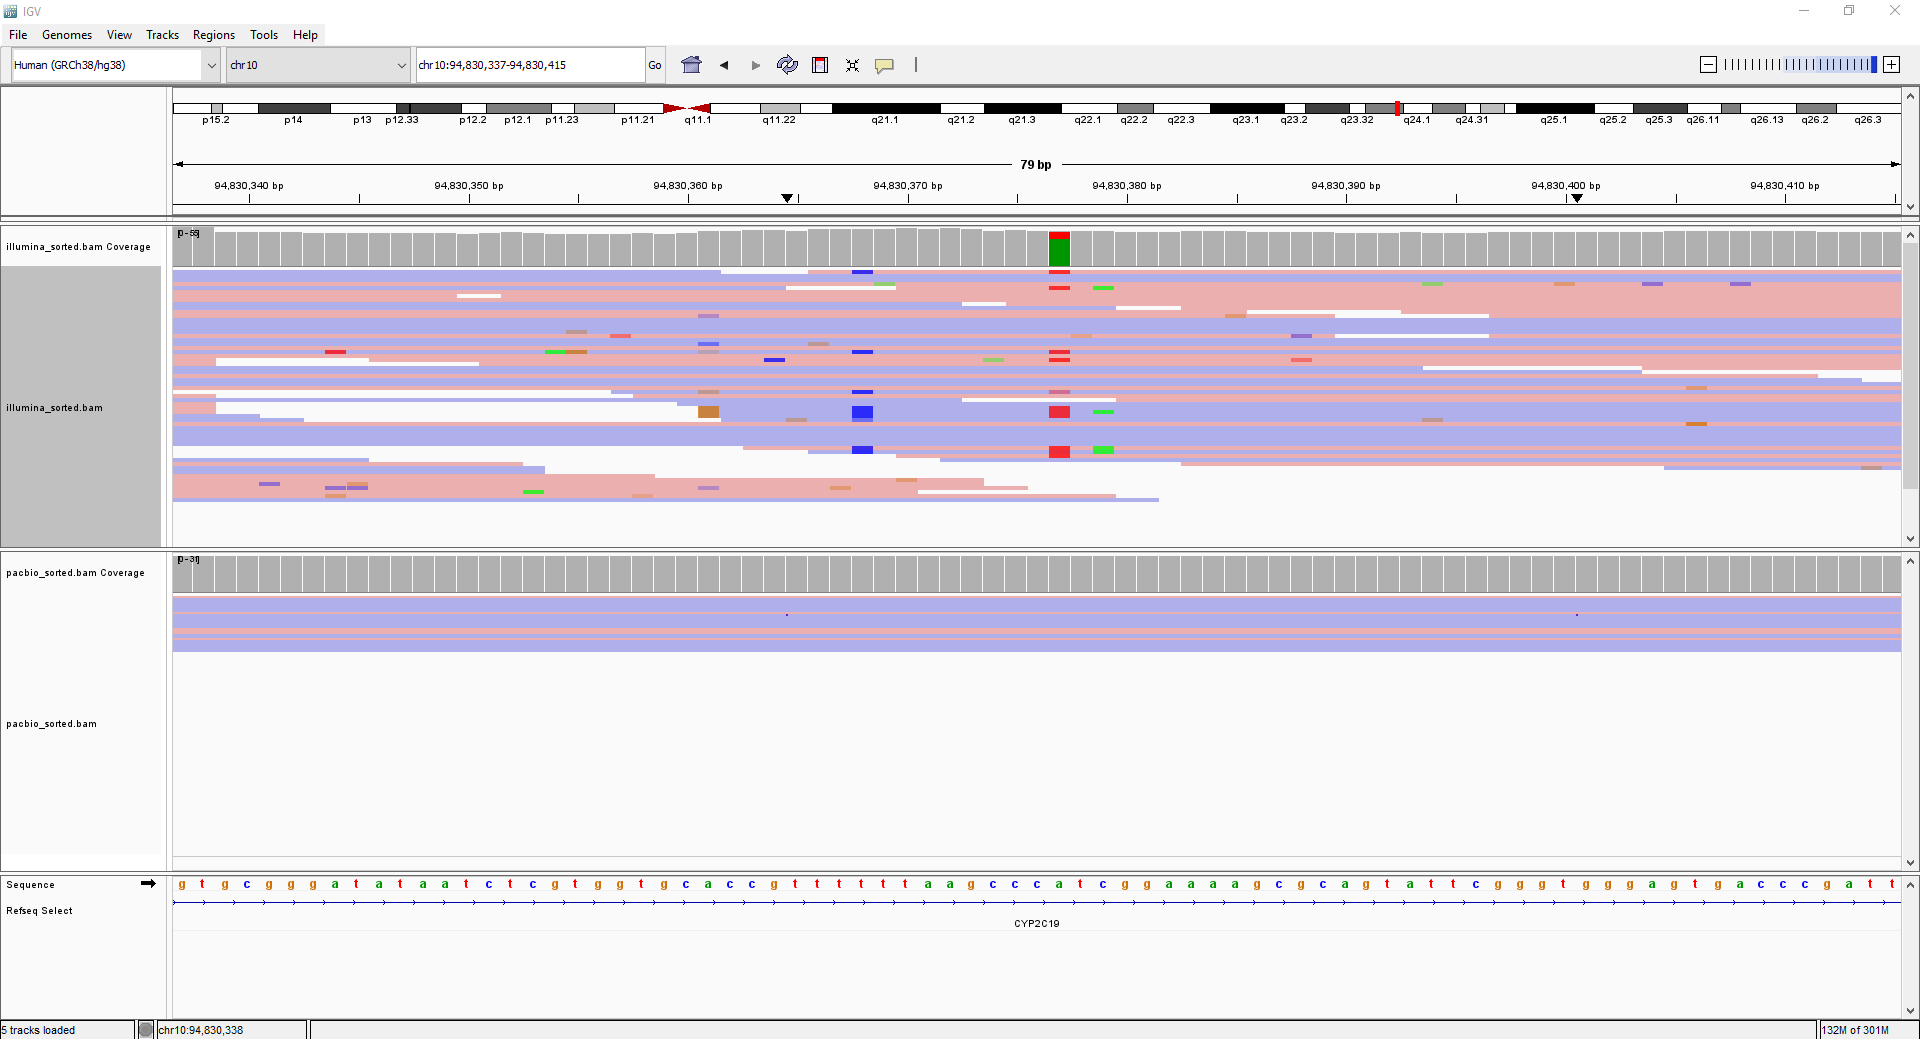

**chr10:94,830,377 (A→T)** - Illumina only  
**True variant**. Illumina shows clear heterozygous signal with ~10 reads supporting both alleles. PacBio simply has no coverage (2 reads total). This is a coverage gap, not an artifact.

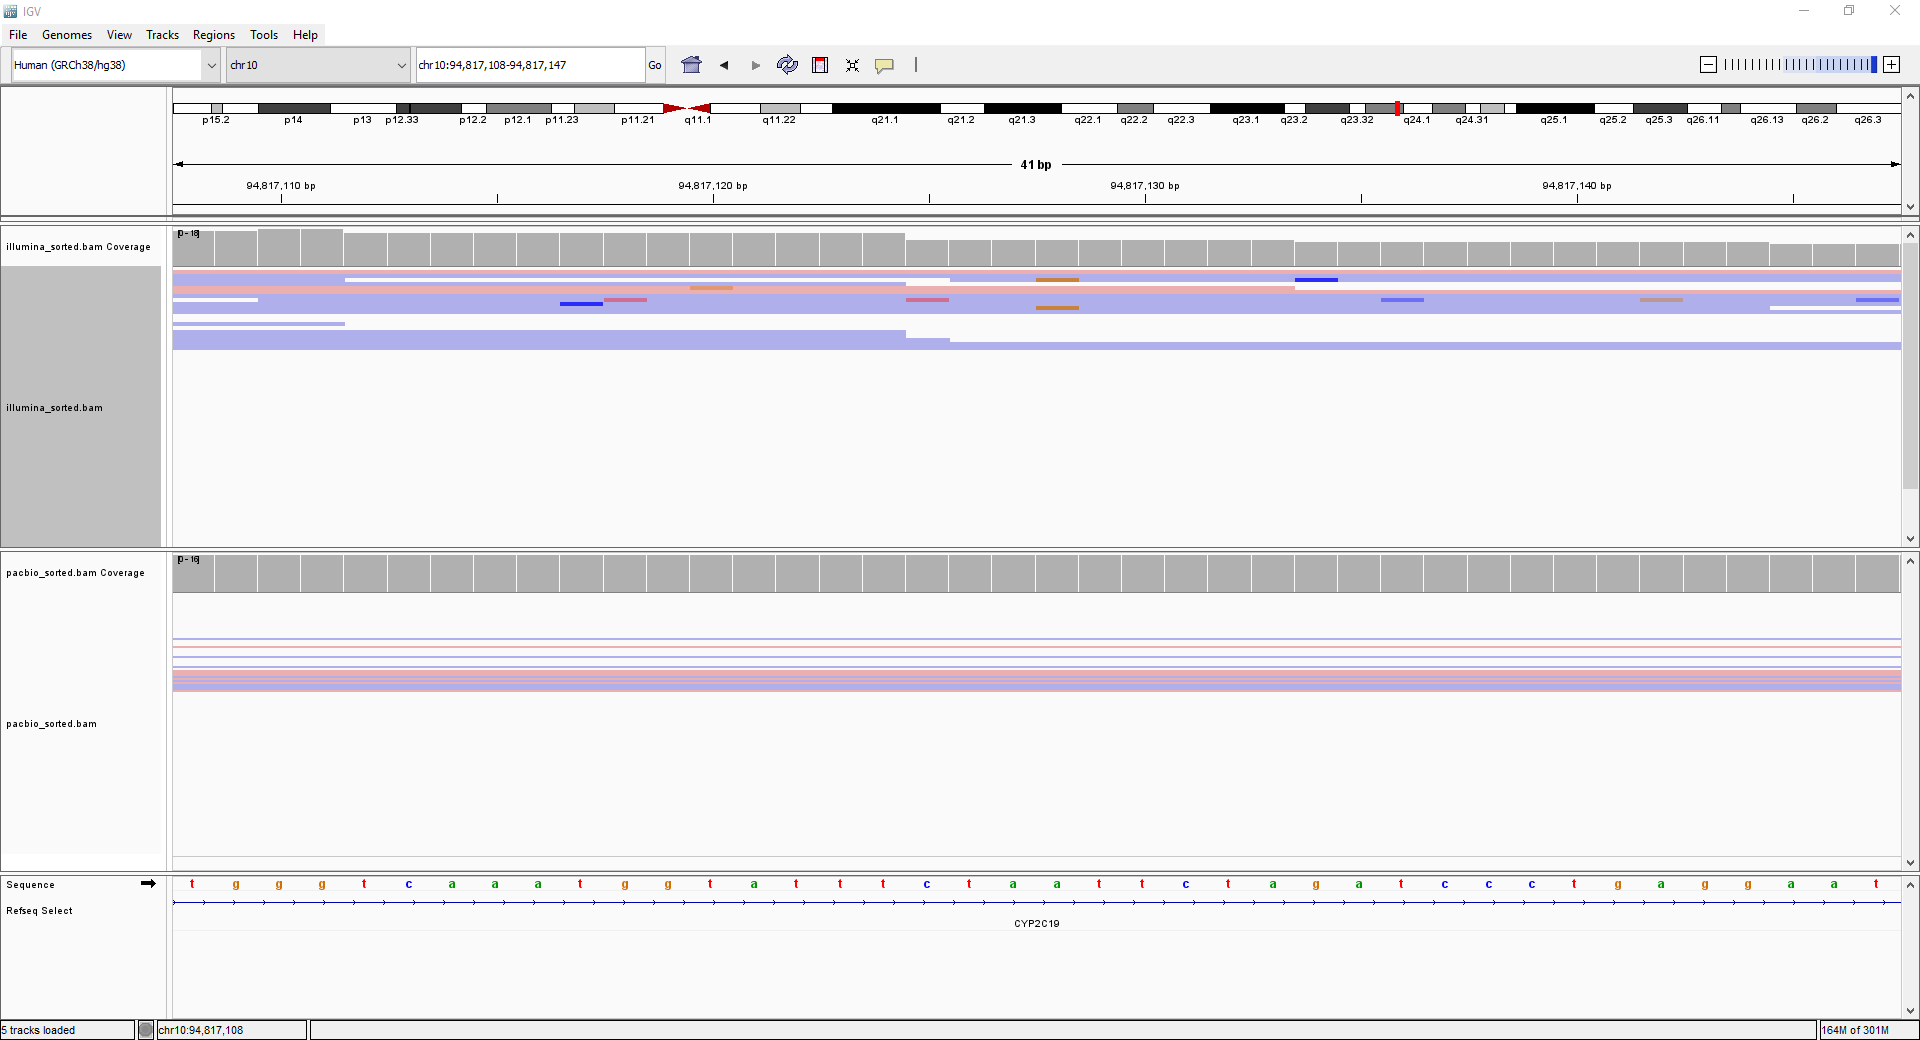

**chr10:94,817,128 (A→G)** - Illumina only  
**Uncertain**. Both technologies have very low coverage (3-4 reads). Insufficient evidence to determine if real or artifact.

---

## **CYP2C8**

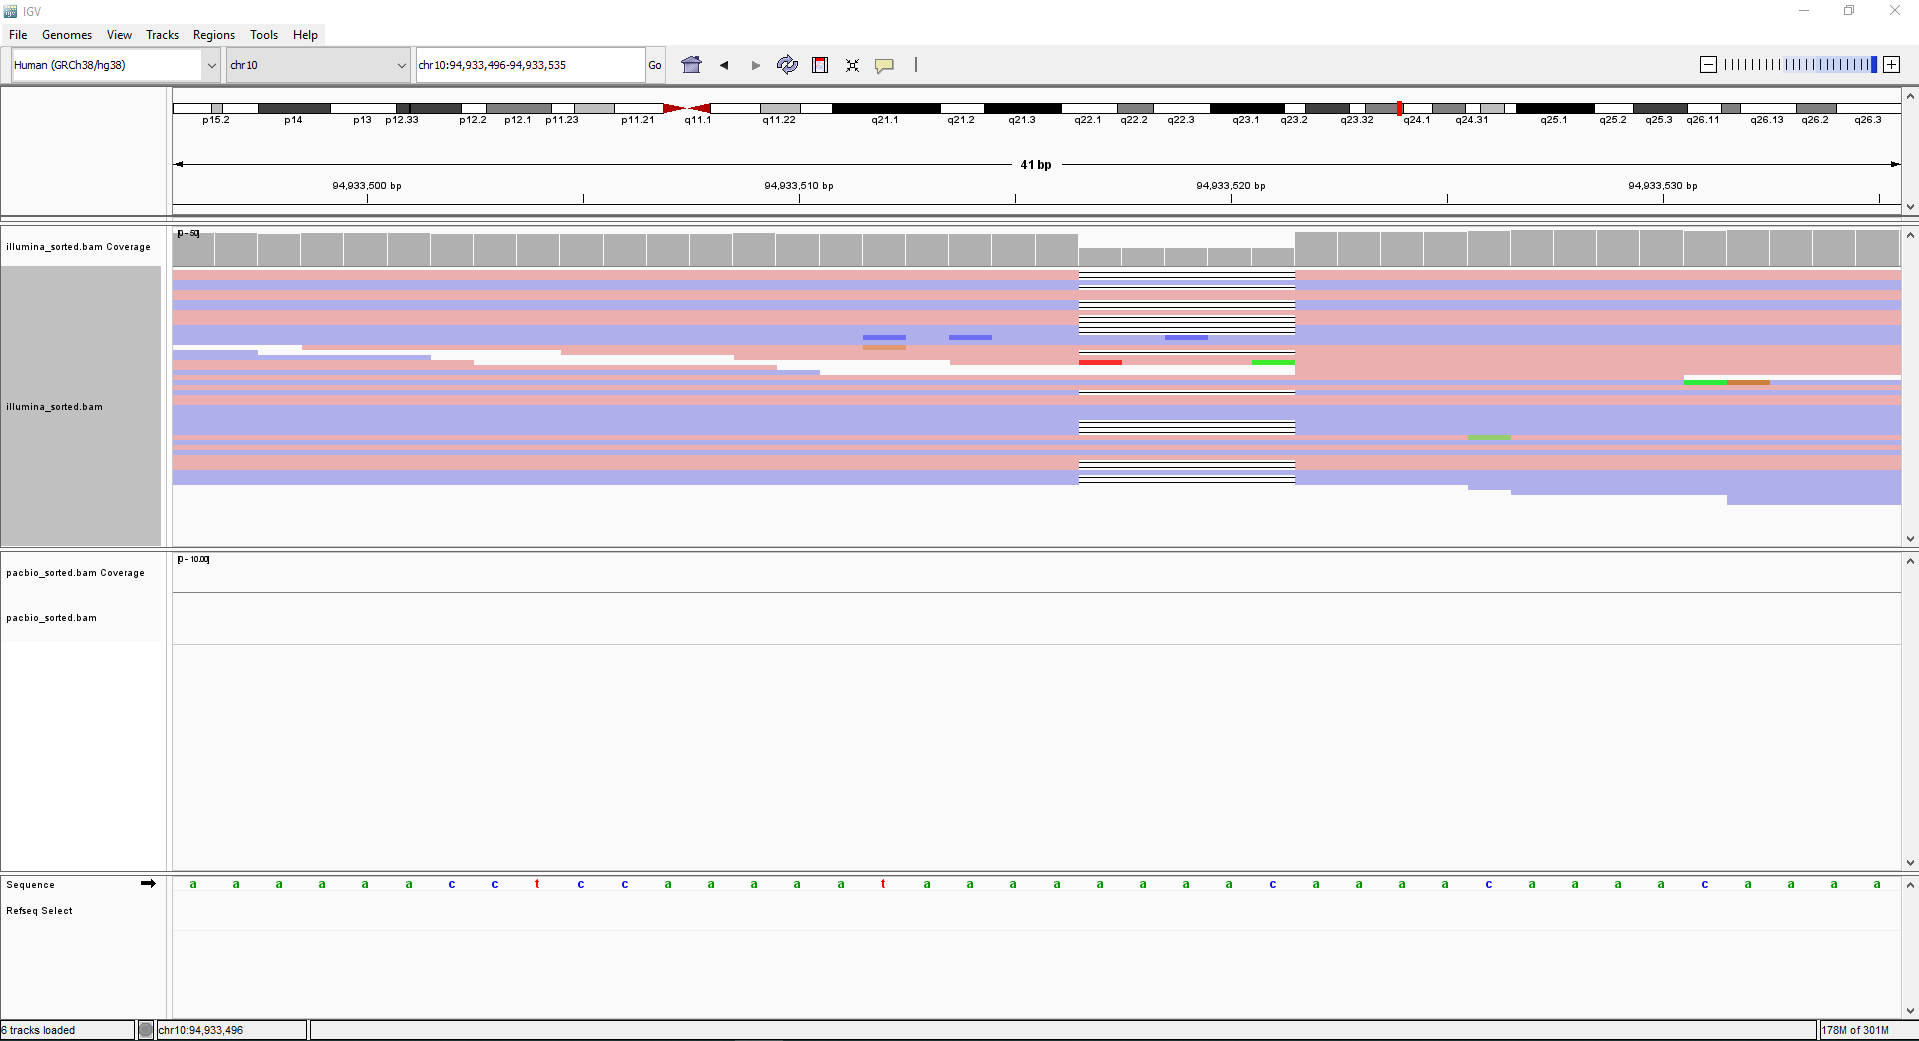

**chr10:94,933,516 (INDEL in aaaa repeat)** - Illumina only  
**True variant**. Illumina clearly shows deletions in the tandem repeat region with multiple supporting reads. PacBio has zero coverage here.

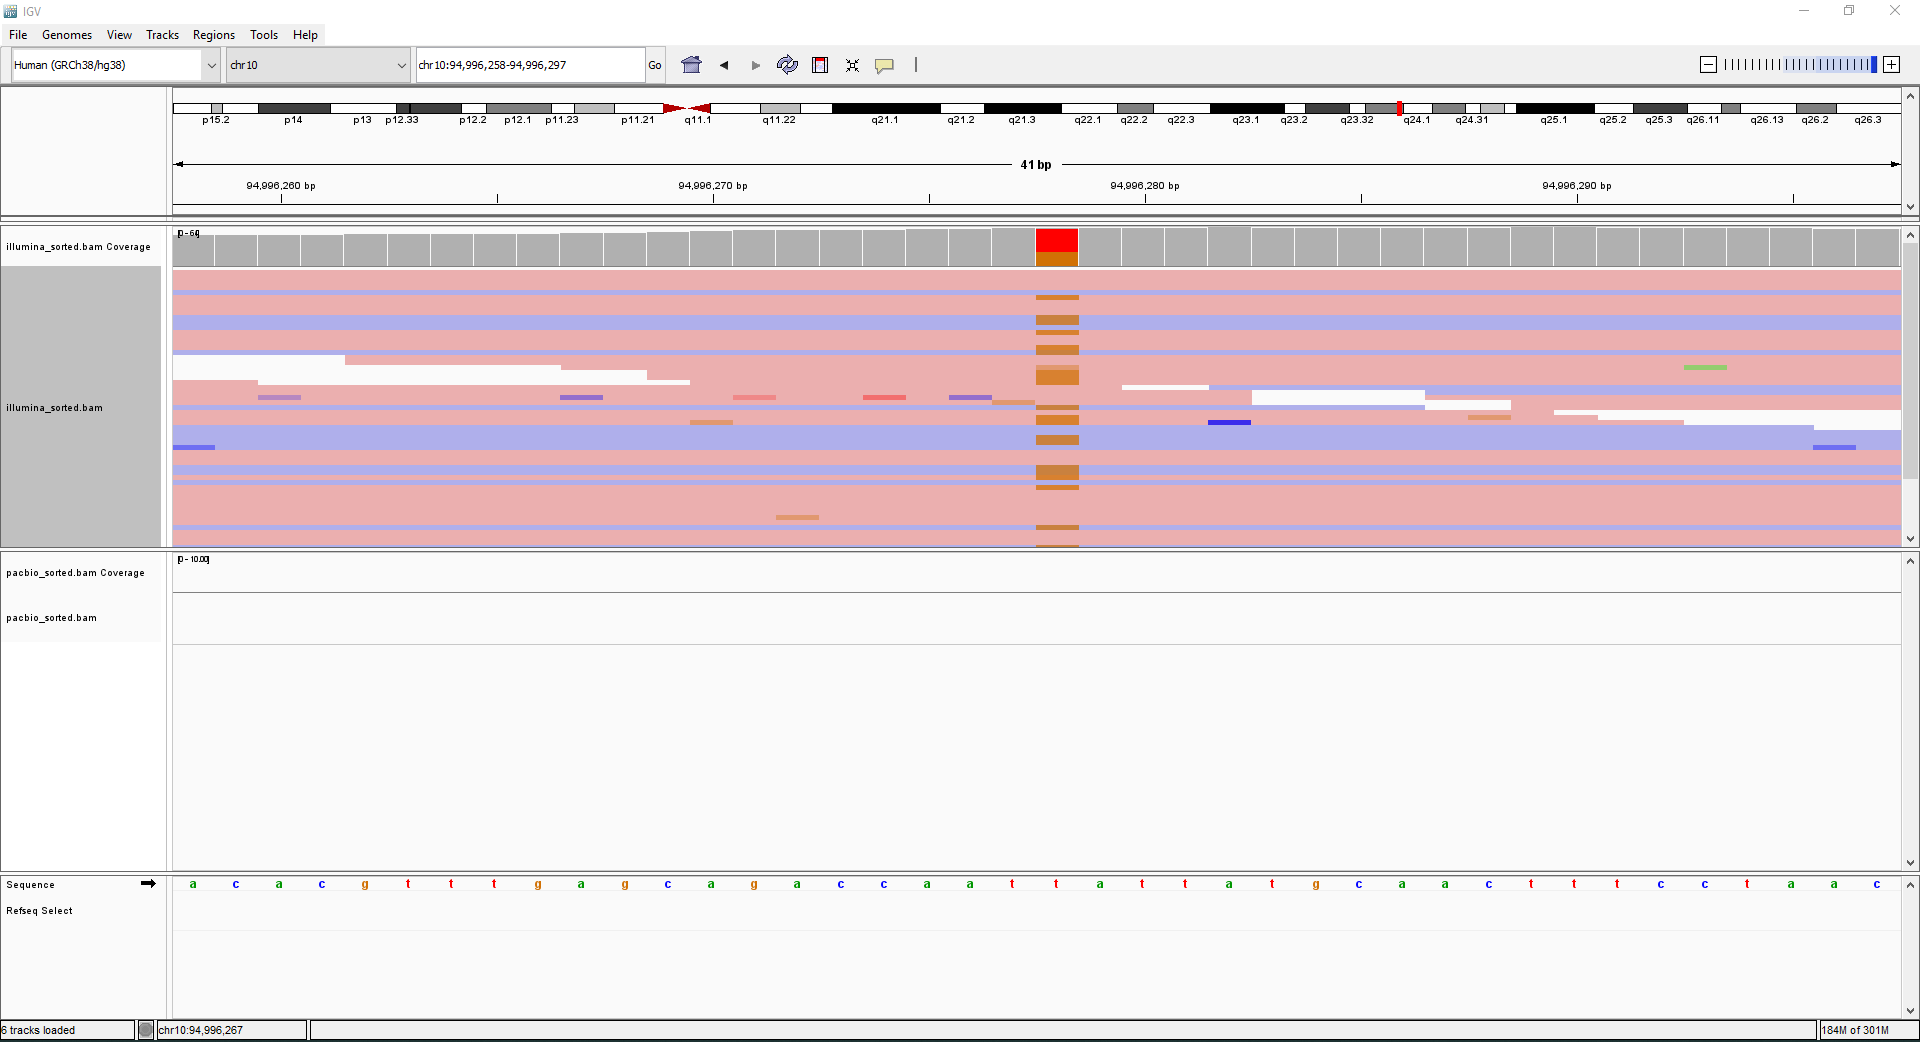

**chr10:94,996,278 (T→G)** - Illumina only  
**True variant**. Illumina shows clear G bases at this position with good read support. PacBio has no reads in this region.

---

## **CYP2C9**

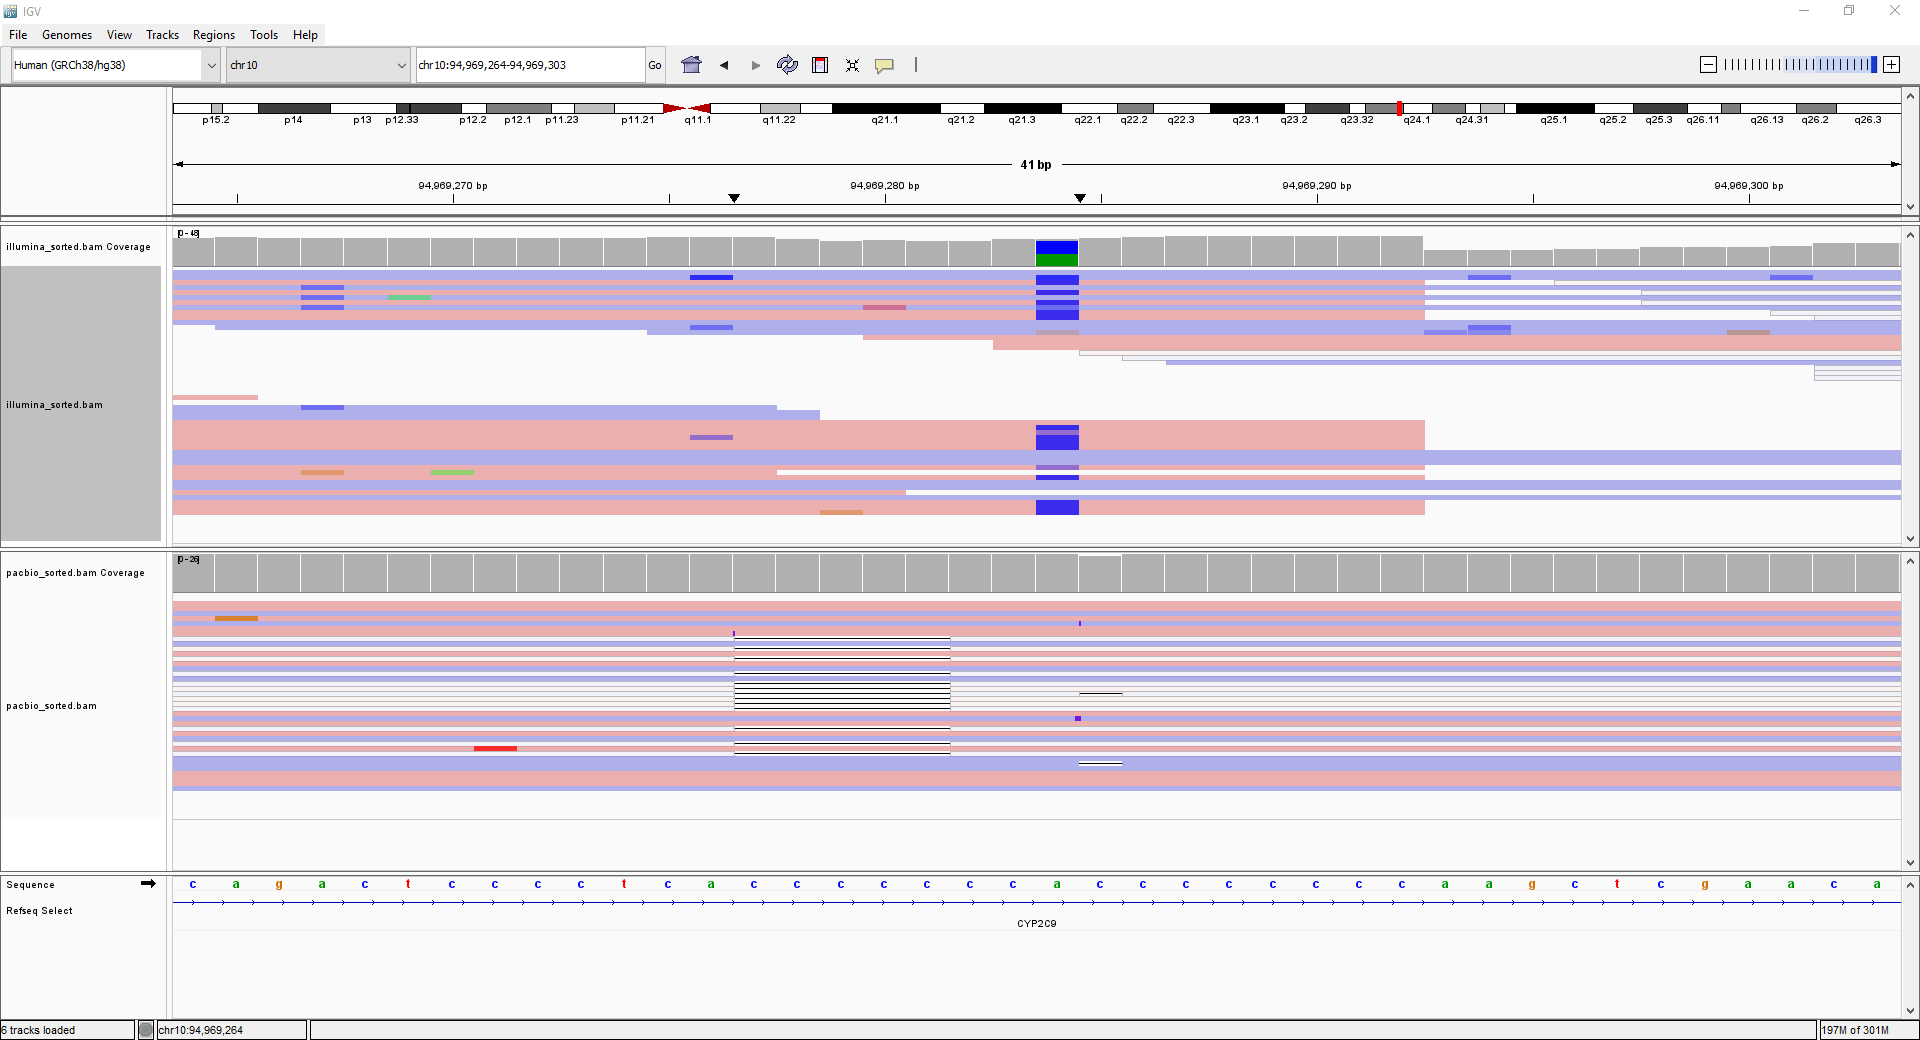

**chr10:94,969,284 (A→C)** - Illumina only  
**Likely true variant**. Illumina shows multiple reads with C bases. PacBio has reads but calls a different variant, suggesting this is a complex region where both technologies struggle with alignment.

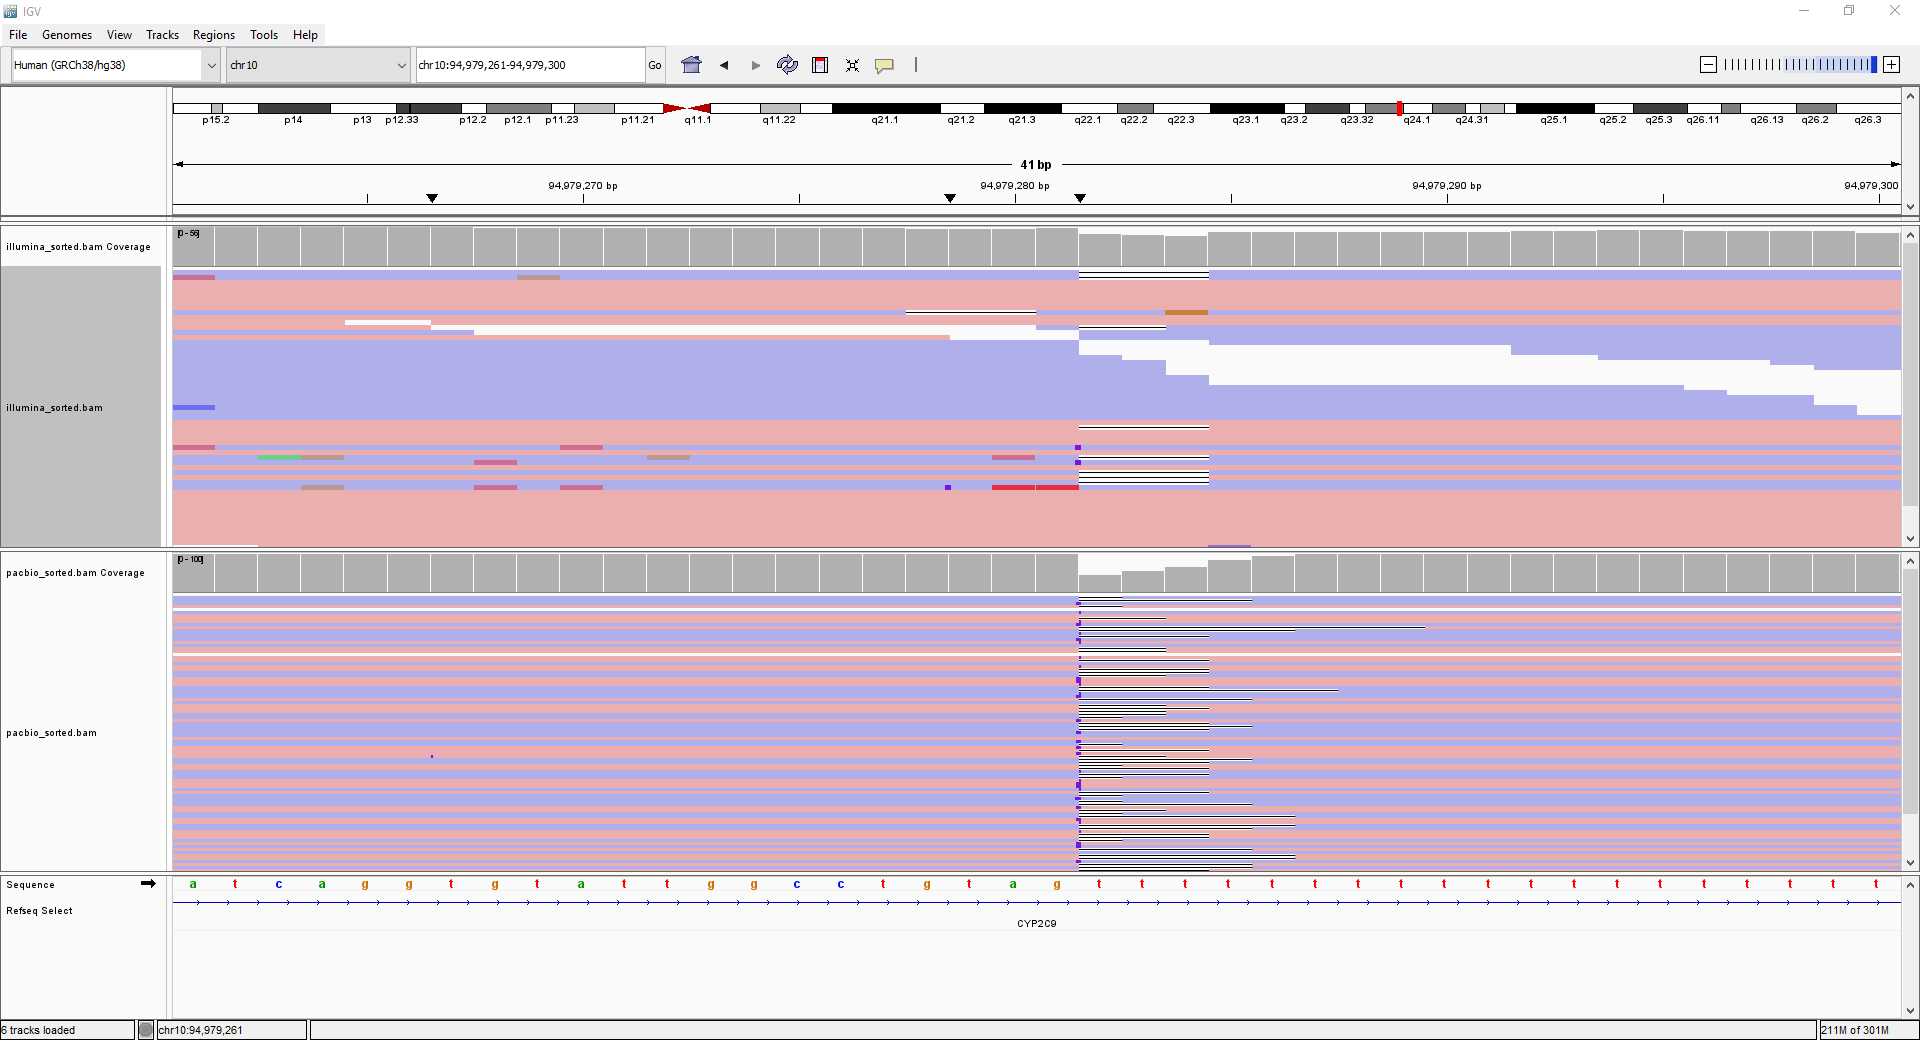

**chr10:94,979,281 (T-repeat INDEL)** - Illumina only  
**Likely artifact**. Both technologies show indels in this poly-T homopolymer tract but disagree on exact length. This is a known problem region where neither technology can accurately determine repeat length. Should be discarded.

## Step 6: Determine Star-Alleles using PharmVar

Can you figure out the star-allele for each gene of interest? The star-allele database can be found in PharmVar; see this for CYP2C19. Your answer should be something like CYP2C19*12 because X, Y and Z. This step does not have to be automated, but should be at least explained in the notebook.

Hint: use phased data!

Expected output: Jupyter cell(s) with discussion (and code, if you want to do it that way).

In [22]:
import subprocess
from pathlib import Path
from collections import defaultdict

GENE_REGIONS = {
    'CYP2C19': {'chr': 'chr10', 'start': 94762681, 'end': 94853816},
    'CYP2C9': {'chr': 'chr10', 'start': 94938683, 'end': 94988917},
    'CYP2C8': {'chr': 'chr10', 'start': 94925451, 'end': 94996427}
}

# Key star-allele defining variants from PharmVar (hg38 coordinates)
# Based on PharmVar database: https://www.pharmvar.org/
STAR_ALLELES = {
    'CYP2C19': {
        # *2 - most common no-function allele
        94781859: {'ref': 'G', 'alt': 'A', 'allele': '*2', 'rsid': 'rs4244285', 'note': '681G>A, splicing defect'},
        # *3 - no function
        94780653: {'ref': 'G', 'alt': 'A', 'allele': '*3', 'rsid': 'rs4986893', 'note': '636G>A, stop codon'},
        # *17 - increased function
        94762706: {'ref': 'C', 'alt': 'T', 'allele': '*17', 'rsid': 'rs12248560', 'note': '-806C>T, promoter'},
    },
    'CYP2C9': {
        # *2 - decreased function
        94942290: {'ref': 'C', 'alt': 'T', 'allele': '*2', 'rsid': 'rs1799853', 'note': '430C>T (Arg144Cys)'},
        # *3 - decreased function  
        94947782: {'ref': 'A', 'alt': 'C', 'allele': '*3', 'rsid': 'rs1057910', 'note': '1075A>C (Ile359Leu)'},
    },
    'CYP2C8': {
        # *2 - altered function
        94947869: {'ref': 'G', 'alt': 'A', 'allele': '*2', 'rsid': 'rs11572080', 'note': '805A>T (Ile269Phe)'},
        # *3 - decreased function
        94938683: {'ref': 'G', 'alt': 'A', 'allele': '*3', 'rsid': 'rs10509681', 'note': '416G>A (Arg139Lys)'},
        94942290: {'ref': 'A', 'alt': 'G', 'allele': '*3', 'rsid': 'rs11572080', 'note': '1196A>G (Lys399Arg)'},
    }
}

def parse_phased_vcf(vcf_path, gene_regions):
    variants_by_gene = {gene: {'hap1': [], 'hap2': [], 'unphased': []} for gene in gene_regions}
    
    cmd = ["bcftools", "view", "-H", str(vcf_path)]
    result = subprocess.run(cmd, capture_output=True, text=True, check=True)
    
    for line in result.stdout.strip().split('\n'):
        if not line or line.startswith('#'):
            continue
        
        fields = line.split('\t')
        chrom, pos, ref, alt = fields[0], int(fields[1]), fields[3], fields[4]
        sample = fields[9] if len(fields) > 9 else ""
        genotype = sample.split(':')[0] if ':' in sample else sample
        
        for gene, region in gene_regions.items():
            if chrom == region['chr'] and region['start'] <= pos <= region['end']:
                variant = {
                    'pos': pos,
                    'ref': ref,
                    'alt': alt,
                    'genotype': genotype
                }
                
                if '|' in genotype:
                    alleles = genotype.split('|')
                    if alleles[0] == '1':  # Variant on haplotype 1
                        variants_by_gene[gene]['hap1'].append(variant)
                    if alleles[1] == '1':  # Variant on haplotype 2
                        variants_by_gene[gene]['hap2'].append(variant)
                else:
                    variants_by_gene[gene]['unphased'].append(variant)
                break
    
    return variants_by_gene

def identify_star_allele(gene, haplotype_variants, star_allele_db):
    detected_alleles = []
    
    for variant in haplotype_variants:
        pos = variant['pos']
        alt = variant['alt']
        
        if pos in star_allele_db:
            expected = star_allele_db[pos]
            if alt == expected['alt']:
                detected_alleles.append({
                    'allele': expected['allele'],
                    'rsid': expected['rsid'],
                    'note': expected['note'],
                    'pos': pos
                })
    
    return detected_alleles

def main():
    print("STAR-ALLELE DETERMINATION")
    
    data_dir = Path("data")
    
    # Use phased VCF files (important!)
    illumina_vcf = data_dir / "illumina_phased.vcf"
    pacbio_vcf = data_dir / "pacbio_phased.vcf"
    
    print("\nUsing phased VCF files for haplotype analysis:")
    print(f"  Illumina: {illumina_vcf.name}")
    print(f"  PacBio:   {pacbio_vcf.name}")
    
    print("\nParsing phased variants...")
    illumina_haplotypes = parse_phased_vcf(illumina_vcf, GENE_REGIONS)
    pacbio_haplotypes = parse_phased_vcf(pacbio_vcf, GENE_REGIONS)
    
    for gene in sorted(GENE_REGIONS.keys()):
        print(f"GENE: {gene}")
        
        if gene not in STAR_ALLELES:
            print(f"  No star-allele database available for {gene}")
            continue
        
        star_db = STAR_ALLELES[gene]
        
        print(f"\nIllumina Haplotypes:")
        print(f"  Haplotype 1: {len(illumina_haplotypes[gene]['hap1'])} variants")
        print(f"  Haplotype 2: {len(illumina_haplotypes[gene]['hap2'])} variants")
        
        ill_hap1_alleles = identify_star_allele(gene, illumina_haplotypes[gene]['hap1'], star_db)
        ill_hap2_alleles = identify_star_allele(gene, illumina_haplotypes[gene]['hap2'], star_db)
        
        if ill_hap1_alleles:
            print(f"\n  Haplotype 1 star-alleles detected:")
            for allele in ill_hap1_alleles:
                print(f"    {allele['allele']}: {allele['note']} ({allele['rsid']})")
        else:
            print(f"  Haplotype 1: *1 (reference/wild-type)")
        
        if ill_hap2_alleles:
            print(f"\n  Haplotype 2 star-alleles detected:")
            for allele in ill_hap2_alleles:
                print(f"    {allele['allele']}: {allele['note']} ({allele['rsid']})")
        else:
            print(f"  Haplotype 2: *1 (reference/wild-type)")
        
        # Analyze PacBio haplotypes
        print(f"\nPacBio Haplotypes:")
        print(f"  Haplotype 1: {len(pacbio_haplotypes[gene]['hap1'])} variants")
        print(f"  Haplotype 2: {len(pacbio_haplotypes[gene]['hap2'])} variants")
        
        pb_hap1_alleles = identify_star_allele(gene, pacbio_haplotypes[gene]['hap1'], star_db)
        pb_hap2_alleles = identify_star_allele(gene, pacbio_haplotypes[gene]['hap2'], star_db)
        
        if pb_hap1_alleles:
            print(f"\n  Haplotype 1 star-alleles detected:")
            for allele in pb_hap1_alleles:
                print(f"    {allele['allele']}: {allele['note']} ({allele['rsid']})")
        else:
            print(f"  Haplotype 1: *1 (reference/wild-type)")
        
        if pb_hap2_alleles:
            print(f"\n  Haplotype 2 star-alleles detected:")
            for allele in pb_hap2_alleles:
                print(f"    {allele['allele']}: {allele['note']} ({allele['rsid']})")
        else:
            print(f"  Haplotype 2: *1 (reference/wild-type)")
        
        print(f"\n  CONSENSUS DIPLOTYPE:")
        hap1 = ill_hap1_alleles[0]['allele'] if ill_hap1_alleles else '*1'
        hap2 = ill_hap2_alleles[0]['allele'] if ill_hap2_alleles else '*1'
        print(f"    {gene} {hap1}/{hap2}")
    

if __name__ == "__main__":
    main()

STAR-ALLELE DETERMINATION

Using phased VCF files for haplotype analysis:
  Illumina: illumina_phased.vcf
  PacBio:   pacbio_phased.vcf

Parsing phased variants...
GENE: CYP2C19

Illumina Haplotypes:
  Haplotype 1: 24 variants
  Haplotype 2: 29 variants
  Haplotype 1: *1 (reference/wild-type)
  Haplotype 2: *1 (reference/wild-type)

PacBio Haplotypes:
  Haplotype 1: 35 variants
  Haplotype 2: 50 variants
  Haplotype 1: *1 (reference/wild-type)
  Haplotype 2: *1 (reference/wild-type)

  CONSENSUS DIPLOTYPE:
    CYP2C19 *1/*1
GENE: CYP2C8

Illumina Haplotypes:
  Haplotype 1: 9 variants
  Haplotype 2: 2 variants
  Haplotype 1: *1 (reference/wild-type)
  Haplotype 2: *1 (reference/wild-type)

PacBio Haplotypes:
  Haplotype 1: 3 variants
  Haplotype 2: 4 variants
  Haplotype 1: *1 (reference/wild-type)
  Haplotype 2: *1 (reference/wild-type)

  CONSENSUS DIPLOTYPE:
    CYP2C8 *1/*1
GENE: CYP2C9

Illumina Haplotypes:
  Haplotype 1: 13 variants
  Haplotype 2: 10 variants
  Haplotype 1: *1 (re

The results (*1/*1 across all genes) suggest no star-allele defining variants were detected, which could mean:

The sample wild-type (*1/*1) or something happened along the way and the code missed real star-allele positions (due to coordinate mismatches, reference build issues, or multi-allelic representation).